In [21]:
%reload_ext autoreload
%autoreload 2
import numpy as np
from SFM import SFM
import cv2
import matplotlib as mpl
import matplotlib.pyplot as plt

%matplotlib inline
mpl.rcParams['figure.dpi']= 200

In [34]:
# path = "test1/imgs"
path = "datasets/templeRing"
# path = "test1/7_1b_imgs_4"


test1 = SFM(path)

frame00064.png: 100%|██████████| 65/65 [00:00<00:00, 136.26it/s]


In [35]:
kp, des = test1.ft_extract()



FEATURE EXTRACTION....


Image 65: 100%|██████████| 65/65 [00:02<00:00, 28.35it/s]


In [36]:
matches = test1.ft_match()


MATCHING...



(63, 64): 100%|██████████| 64/64 [00:18<00:00,  3.46it/s]

Elapsed Time: 18.51002335548401




In [37]:
adj_list, pairs = test1.adj_list()

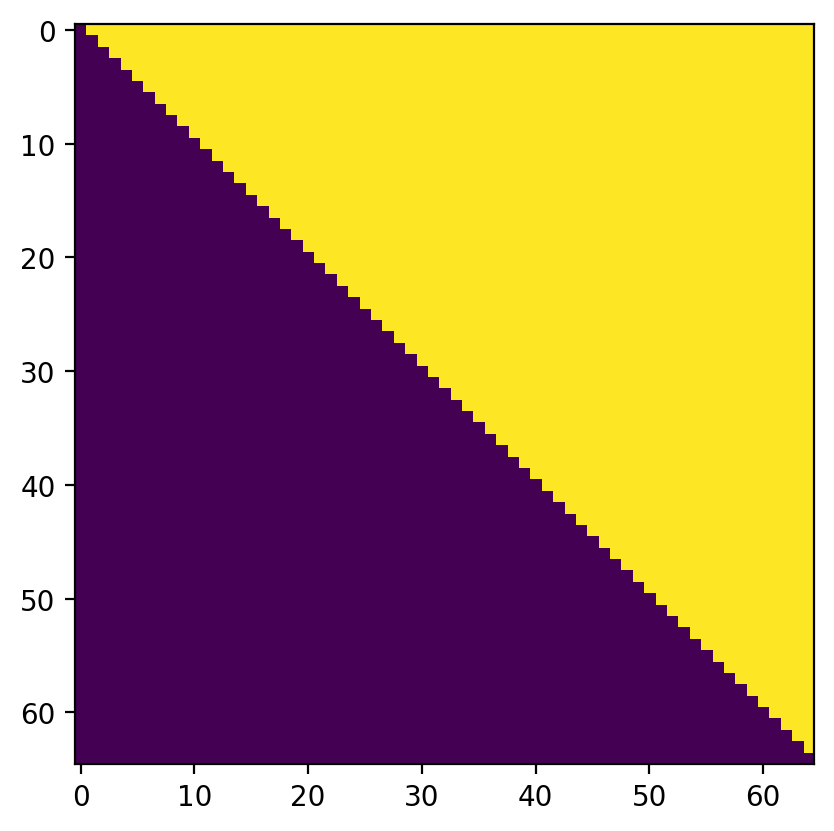

In [38]:
plt.imshow(adj_list)

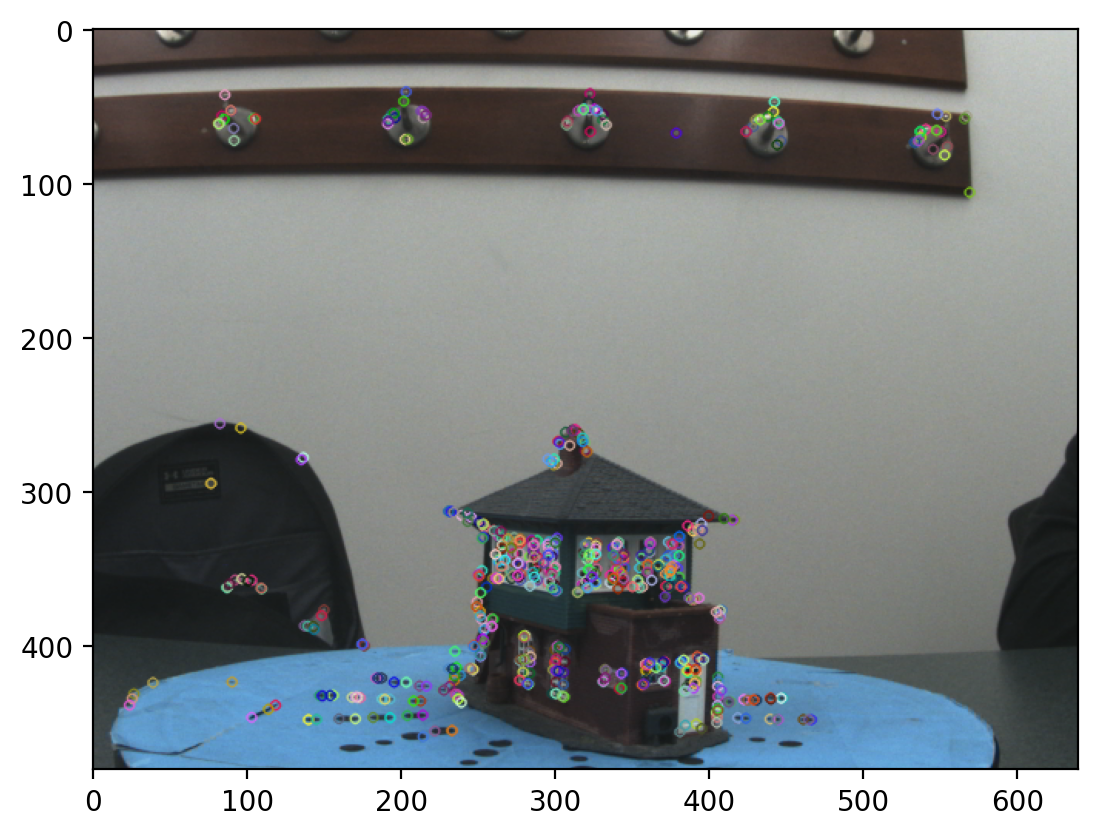

In [41]:
i = 3
plt.imshow(cv2.drawKeypoints(test1.im[i][:,:,::-1], test1.kp[i], None))